# Creating the External Forcing Conditions

This notebook serves as a demo for the creation of the external forcing conditions. These initial conditions are shown for Mike's Calfornia Current regional model. You can follow and/or adapt this notebook based on your configuration.

First, import packages to re-create and visualize the model fields here:

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import cmocean.cm as cm
import xarray as xr

Next, define the location of the input directory for the model. This is the same directory that holds the bathymetry file generated in the previous notebooks for this model example.

In [2]:
# define the input directory
input_dir = '/Users/masonjones/Desktop/MS274/W9'

## Constructing the External Forcing Conditions
For this example, I will use the external forcing fields from the ECCO Version 5 state estimate. I will prepare these fields in 5 steps:
1. download 7 external forcing fields used in the ECCO model
2. read the external forcing fields used in the ECCO model as well as the ECCO grid
3. read in the bathymetry for my model as well as its grid
4. interpolate the ECCO fields onto my model grid and store each as a binary file
5. plot the interpolated fields to ensure they look as expected

### Step 1: Download the ECCO fields
To begin, I downloaded the model fields generated by the ECCO Version 4 Alpha state estimate. These fields are available [HERE](https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/input_forcing). In particular, I downloaded the following list of files that contain the field pertaining to starting point of my model (January 2008):

| Variable(s) | File Name |
| -------- | --------- |
|Atmospheric Temperature|[eccov4r4_tmp2m_degC_2008](https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/input_forcing/eccov4r4_tmp2m_degC_2008)|
|Specific Humidity|[eccov4r4_spfh2m_2008](https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/input_forcing/eccov4r4_spfh2m_2008)|
|Precipitation|[eccov4r4_rain_2008](https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/input_forcing/eccov4r4_rain_2008)|
|Downwelling Shortwave Radiation|[eccov4r4_dsw_2008](https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/input_forcing/eccov4r4_dsw_2008)|
|Downwelling Longwave Radiation|[eccov4r4_dlw_2008](https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/input_forcing/eccov4r4_dlw_2008)|
|Zonal Wind Stress|[eccov4r4_ustr_2008](https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/input_forcing/eccov4r4_ustr_2008)|
|Meridional Wind Stress|[eccov4r4_vstr_2008](https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/input_forcing/eccov4r4_vstr_2008)|
|Wind Speed|[eccov4r4_wspeed_2008](https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/input_forcing/eccov4r4_wspeed_2008)|

Here, I also specify the year to use later in this notebook

In [28]:
year = 2000

I stored these fields in the same directory as this notebook:

In [29]:
data_folder = '/Users/masonjones/Desktop/MS274/W9'

### Step 2: Read in the ECCO grid
To read in the ECCO fields, I will rely on the grid parameters from the grid file:

In [30]:
ds = nc4.Dataset('GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ecco_XC_tiles = ds.variables['XC'][:,:,:]
ecco_YC_tiles = ds.variables['YC'][:,:,:]
ecco_hFacC_tiles = ds.variables['hFacC'][:,:,:,:]
ecco_hFacS_tiles = ds.variables['hFacS'][:,:,:,:]
ecco_hFacW_tiles = ds.variables['hFacW'][:,:,:,:]
ecco_RF_tiles = ds.variables['Z'][:]
ds.close()

As described [HERE](https://profmikewood.github.io/ocean_modeling_book/ecco/ecco_llc_grid.html), the ECCO grid has 13 tiles but only 1 or 2 may pertain to my local area. To determine which tiles correspond to my region, I'll read in my model grid next.

### Step 3: Read in the Model Grid and Generate a Mask
Here, I will recreate the grid I will use in my model and read in the bathymetry file (see previous notebooks for details):

In [31]:
# define the parameters that will be used in the data file
delX = 547/8000000
delY = 225291667/1000000000000
xgOrigin = -121.79820967558051
ygOrigin = 36.774869659553836
n_rows = 240
n_cols = 240

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
ds = xr.open_dataset(os.path.join(input_dir, "Monterey_Bay_Canyon_Head_Bathymetry.nc"))
# build a DataArray with matching dim names
lat = ds["latitude"].values      # (101,)
lon = ds["longitude"].values     # (121,)
z = xr.DataArray(
    ds["elevation"].values,      # (rows=101, cols=121)
    dims=("latitude", "longitude"),
    coords={"latitude": lat, "longitude": lon},
)

# interpolate to your target lon/lat grids (same shape as XC/YC → 240x240)
bathy = z.interp(latitude=(("y","x"), YC), longitude=(("y","x"), XC)).values


With an eye toward the interpolation to come next, I will make a mask to determine where the interpolatation will take place. I will create this mask by recreating the `hFac` field for my model using the `hFac` module from the `eccoseas` package: 

In [32]:
from eccoseas.downscale import hFac

In [33]:
depth = bathy
delR = np.array([ 1.00,    1.14,    1.30,    1.49,   1.70,
                  1.93,    2.20,    2.50,    2.84,   3.21,
                  3.63,    4.10,    4.61,    5.18,   5.79,
                  6.47,    7.20,    7.98,    8.83,   9.73,
                 10.69,   11.70,   12.76,   13.87,  15.03,
                 16.22,   17.45,   18.70,   19.97,  21.27,
                 22.56,   23.87,   25.17,   26.46,  27.74,
                 29.00,   30.24,   31.45,   32.65,  33.82,
                 34.97,   36.09,   37.20,   38.29,  39.37,
                 40.45,   41.53,   42.62,   43.73,  44.87,
                 46.05,   47.28,   48.56,   49.93,  51.38,
                 52.93,   54.61,   56.42,   58.38,  60.53,
                 62.87,   65.43,   68.24,   71.33,  74.73,
                 78.47,   82.61,   87.17,   92.21,  97.79,
                103.96,  110.79,  118.35,  126.73, 136.01,
                146.30,  157.71,  170.35,  184.37, 199.89,
                217.09,  236.13,  257.21,  280.50, 306.24,
                334.64,  365.93,  400.38,  438.23, 479.74,])
hFacC = hFac.create_hFacC_grid(depth, delR)

The mask is generated by setting all of the non-zero `hFac` points to 1:

In [34]:
mask = np.copy(hFacC)
mask[mask>0] = 1

To double check the mask was created as expected, I will plot it in comparison to the bathymetry here:

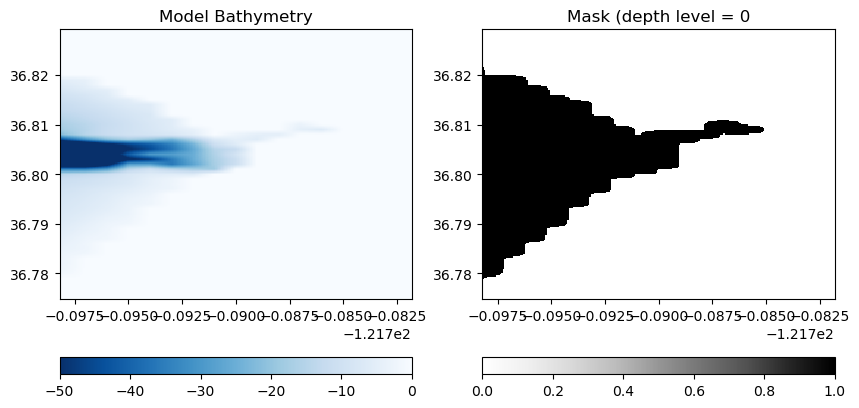

In [35]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-50, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask[0], vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Mask (depth level = '+str(depth_level))

plt.show()

Seems reasonable!

### Step 4: Prepare the grids for interpolation
At this point, we can use the geometry of both grids to check to see which tiles have the information we need. After some trial and error (and referencing the ECCO page), I find that tiles 7 and 10 have the points I need:

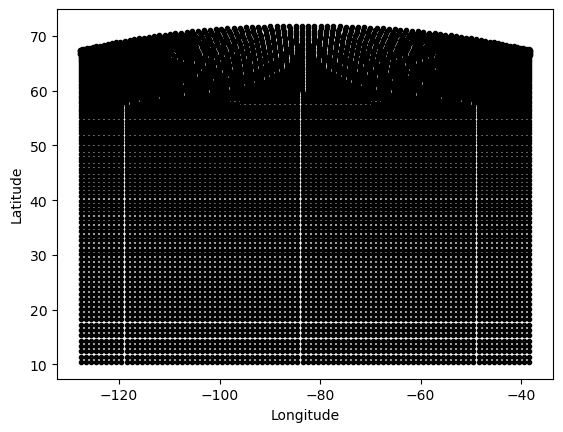

In [36]:
# plot the ECCO tile points from tiles 7 and 10
plt.plot(ecco_XC_tiles[10],ecco_YC_tiles[10],'k.')


# plot the boundary of the CA model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

As we can see, my model boundary (green) is completely surrounded by the points in tile 8 and 11 (black). I also note that there is extraneous information in points with longitude greater than ~140 - I will omit these points as well. Given these observations, now I read in points from just those tiles to use in interpolation:

In [37]:
tile_list = [10]

# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# determine the number of timesteps
if year%4==0:
    n_timesteps = 366*4
else:
    n_timesteps = 365*4

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_hFacC_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_hFacW_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_hFacS_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_maskC_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_maskS_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_maskW_points = np.zeros((np.size(ecco_RF_tiles) , total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()
    
    for k in range(np.size(ecco_RF_tiles)):
        level_hFacC = ecco_hFacC_tiles[k, tile_number, :, :]
        level_hFacW = ecco_hFacW_tiles[k, tile_number, :, :]
        level_hFacS = ecco_hFacS_tiles[k, tile_number, :, :]
        level_mask_C = np.copy(level_hFacC)
        level_mask_C[level_mask_C>0] = 1
        level_mask_W = np.copy(level_hFacW)
        level_mask_W[level_mask_W>0] = 1
        level_mask_S = np.copy(level_hFacS)
        level_mask_S[level_mask_S>0] = 1
        ecco_hFacC_points[k, points_counted:points_counted+tile_N] = level_hFacC.ravel()
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        ecco_maskC_points[k,points_counted:points_counted+tile_N] = level_mask_C.ravel()
        ecco_maskW_points[k,points_counted:points_counted+tile_N] = level_mask_W.ravel()
        ecco_maskS_points[k,points_counted:points_counted+tile_N] = level_mask_S.ravel()
    
    points_counted += tile_N

# remove the points with positive longitude
local_indices = ecco_XC_points<0
ecco_maskC_points = ecco_maskC_points[:, local_indices]
ecco_maskS_points = ecco_maskS_points[:, local_indices]
ecco_maskW_points = ecco_maskW_points[:, local_indices]
ecco_hFacC_points = ecco_hFacC_points[:, local_indices]
ecco_hFacW_points = ecco_hFacW_points[:, local_indices]
ecco_hFacS_points = ecco_hFacS_points[:, local_indices]
ecco_YC_points = ecco_YC_points[local_indices]
ecco_XC_points = ecco_XC_points[local_indices]

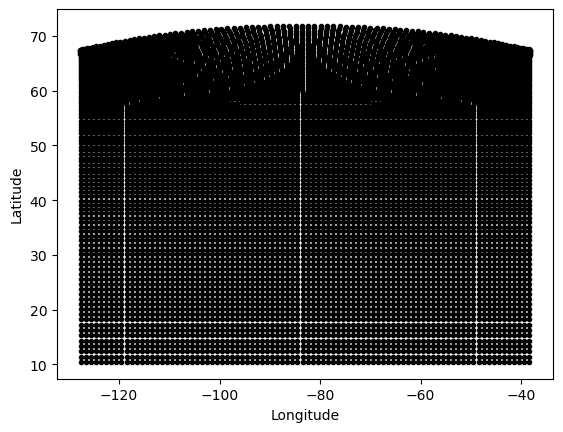

In [38]:
# plot the subsetted ECCO points
plt.plot(ecco_XC_points,ecco_YC_points,'k.')

# plot the boundary of the CA model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Next, we'll read in the real data fields and apply the modifications. First, create a dictionary to store the file names:

In [39]:
# make a file dictionary to loop over

# test dictionary
file_prefix_dict = {'ATEMP':'eccov4r4_tmp2m_degC'}

# once tested with the above dict, run and comment with this one
file_prefix_dict = {'ATEMP':'eccov4r4_tmp2m_degC',
                   'AQH':'eccov4r4_spfh2m',
                   'PRECIP':'eccov4r4_rain',
                   'SWDOWN':'eccov4r4_dsw',
                   'LWDOWN':'eccov4r4_dlw',
                   'UWIND':'eccov4r4_ustr',
                   'VWIND':'eccov4r4_vstr',
                   'WINDSPEED':'eccov4r4_wspeed'}

variable_names = list(file_prefix_dict.keys())
if 'WINDSPEED' in variable_names:
    variable_names.pop(variable_names.index('WINDSPEED'))

Now, read the initial condition fields from the same tiles:

In [40]:
from eccoseas.ecco import io
from eccoseas.ecco import grid as eccogrid

In [44]:
np.fromfile(os.path.join(data_folder,file_prefix_dict[variable_name]+'_'+str(year)), dtype='>f4')

array([0.        , 0.        , 0.        , ..., 0.00456791, 0.0043136 ,
       0.00415612], shape=(63700992,), dtype='>f4')

In [45]:
# make a list to hold all of the ECCO grids
exf_grids = []

if year%4==0:
    n_timesteps = 366*4
else:
    n_timesteps = 365*4

# loop through each variable to read in the grid
for variable_name in variable_names:
    
    if 'WIND' in variable_name:
        ustress_faces = io.read_ecco_field_to_faces(os.path.join(data_folder,file_prefix_dict['UWIND']+'_'+str(year)),
                                                llc=90, dim=3, Nr=n_timesteps, dtype='>f4')
        ustress_tiles = eccogrid.ecco_faces_to_tiles(ustress_faces, llc=90, dim=3)
        
        vstress_faces = io.read_ecco_field_to_faces(os.path.join(data_folder,file_prefix_dict['VWIND']+'_'+str(year)),
                                                llc=90, dim=3, Nr=n_timesteps, dtype='>f4')
        vstress_tiles = eccogrid.ecco_faces_to_tiles(vstress_faces, llc=90, dim=3)
        
        speed_faces = io.read_ecco_field_to_faces(os.path.join(data_folder,file_prefix_dict['WINDSPEED']+'_'+str(year)),
                                                llc=90, dim=3, Nr=n_timesteps, dtype='>f4')
        speed_tiles = eccogrid.ecco_faces_to_tiles(speed_faces, llc=90, dim=3)

        uwind_tiles = {}
        vwind_tiles = {}
        for tile in list(speed_tiles.keys()):
            stress = (ustress_tiles[tile]**2 + vstress_tiles[tile]**2)**0.5
            uwind_tiles[tile] = speed_tiles[tile]*ustress_tiles[tile]
            uwind_tiles[tile][stress!=0] /= stress[stress!=0]
            vwind_tiles[tile] = speed_tiles[tile]*vstress_tiles[tile]
            vwind_tiles[tile][stress!=0] /= stress[stress!=0]
        
    else:
        exf_faces = io.read_ecco_field_to_faces(os.path.join(data_folder,file_prefix_dict[variable_name]+'_'+str(year)),
                                                llc=90, dim=3, Nr=n_timesteps, dtype='>f4')
        exf_tiles = eccogrid.ecco_faces_to_tiles(exf_faces, llc=90, dim=3)
    
    # create a grid of zeros to fill in
    N = 90*90
    exf_grid = np.zeros((n_timesteps, N*len(tile_list)))

    # loop through the tiles
    points_counted = 0
    for tile_number in tile_list:
        if 'WIND' in variable_name: # when using velocity, need to consider the tile rotations
            if variable_name == 'UWIND':
                if tile_number<6:
                    for k in range(n_timesteps):
                        exf_grid[k,points_counted:points_counted+N] = \
                             uwind_tiles[tile_number+1][k, :, :].ravel()
                else:
                    for k in range(n_timesteps):
                        exf_grid[k,points_counted:points_counted+N] = \
                             vwind_tiles[tile_number+1][k, :, :].ravel()
            if variable_name == 'VWIND':
                if tile_number<6:
                    for k in range(n_timesteps):
                        exf_grid[k,points_counted:points_counted+N] = \
                             vwind_tiles[tile_number+1][k, :, :].ravel()
                else:
                    for k in range(n_timesteps):
                        exf_grid[k,points_counted:points_counted+N] = \
                             -1*uwind_tiles[tile_number+1][k, :, :].ravel()
        else:
            for k in range(n_timesteps):
                exf_grid[k,points_counted:points_counted+N] = \
                     exf_tiles[tile_number+1][k, :, :].ravel()
        points_counted += N

    # remove the points with positive longitudes
    exf_grid = exf_grid[:,local_indices]

    # add to the stack
    exf_grids.append(exf_grid)

### Step 5: Interpolate the Fields onto the Model Grid
Next, I will interpolate the ECCO external fields I read in onto my model domain. I will use the `horizonal` module from the `eccoseas` package to accomplish this interpolation.

In [47]:
from eccoseas.downscale import horizontal

In [48]:
if 'exf' not in os.listdir(input_dir):
    os.mkdir(os.path.join(input_dir,'exf'))

In [49]:
# loop through each variable and corresponding ECCO grid
for variable_name, exf_grid in zip(variable_names, exf_grids):

    # print a message to keep track of which variable we are working on
    # uncomment to use
    print('    - Interpolating the '+variable_name+' grid')

    if variable_name == 'UWIND':
        ecco_mask_points = ecco_maskS_points
    elif variable_name == 'VWIND':
        ecco_mask_points = ecco_maskW_points
    else:
        model_mask = mask
        ecco_mask_points = ecco_maskC_points

    interpolated_grid = np.zeros((np.shape(exf_grid)[0], np.shape(XC)[0], np.shape(YC)[1]))
    print('RUNNING ONLY FOR 1 TIMESTEP FOR TESTING!')
    for timestep in range(1):#np.shape(exf_grid)[0]):
        if timestep%100==0:
            print('     - Working on timesteps '+str(timestep)+' to '+str(min(timestep+100,np.shape(exf_grid)[0])))
        interpolated_grid[timestep,:,:] = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                           exf_grid[timestep:timestep+1,:], ecco_mask_points[:1,:], 
                                                           XC, YC, model_mask[:1,:,:])

    # convert ECCO values to MITgcm defaults
    if variable_name=='ATEMP':
        interpolated_grid[interpolated_grid!=0] += 273.15
    if variable_name in ['SWDOWN','LWDOWN']:
        interpolated_grid *=-1

    # output the interpolated grid
    output_file = os.path.join(input_dir,'exf',variable_name+'_'+str(year))
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

    - Interpolating the ATEMP grid
RUNNING ONLY FOR 1 TIMESTEP FOR TESTING!
     - Working on timesteps 0 to 100
    - Interpolating the AQH grid
RUNNING ONLY FOR 1 TIMESTEP FOR TESTING!
     - Working on timesteps 0 to 100
    - Interpolating the PRECIP grid
RUNNING ONLY FOR 1 TIMESTEP FOR TESTING!
     - Working on timesteps 0 to 100
    - Interpolating the SWDOWN grid
RUNNING ONLY FOR 1 TIMESTEP FOR TESTING!
     - Working on timesteps 0 to 100
    - Interpolating the LWDOWN grid
RUNNING ONLY FOR 1 TIMESTEP FOR TESTING!
     - Working on timesteps 0 to 100
    - Interpolating the UWIND grid
RUNNING ONLY FOR 1 TIMESTEP FOR TESTING!
     - Working on timesteps 0 to 100
    - Interpolating the VWIND grid
RUNNING ONLY FOR 1 TIMESTEP FOR TESTING!
     - Working on timesteps 0 to 100


### Step 6: Plotting the External Forcing Condition Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

In [50]:
meta_dict = {'ATEMP':[273, 290, cm.thermal, '$^{\circ}$C'],
             'AQH':[0, 0.025, cm.tempo, 'kg/kg'],
             'PRECIP':[0, 1e-6, cm.tempo, 'm/s'],
             'SWDOWN':[-10,20,cm.solar,'W/m$^2$'],
             'LWDOWN':[-100, 500,cm.solar,'W/m$^2$'],
             'UWIND':[-20, 20, cm.balance, 'm/s'],
             'VWIND':[-20, 20, cm.balance, 'm/s'],
             'RUNOFF':[0, 2e-8, cm.tempo, 'm/s']}

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
/var/folders/1r/t68krq4s0wj7kws_smvpp4nw0000gn/T/ipykernel_59603/1147585004.py:1: SyntaxWarning: invalid escape sequence '\c'
  meta_dict = {'ATEMP':[273, 290, cm.thermal, '$^{\circ}$C'],


Then, I'll create all of the subplots:

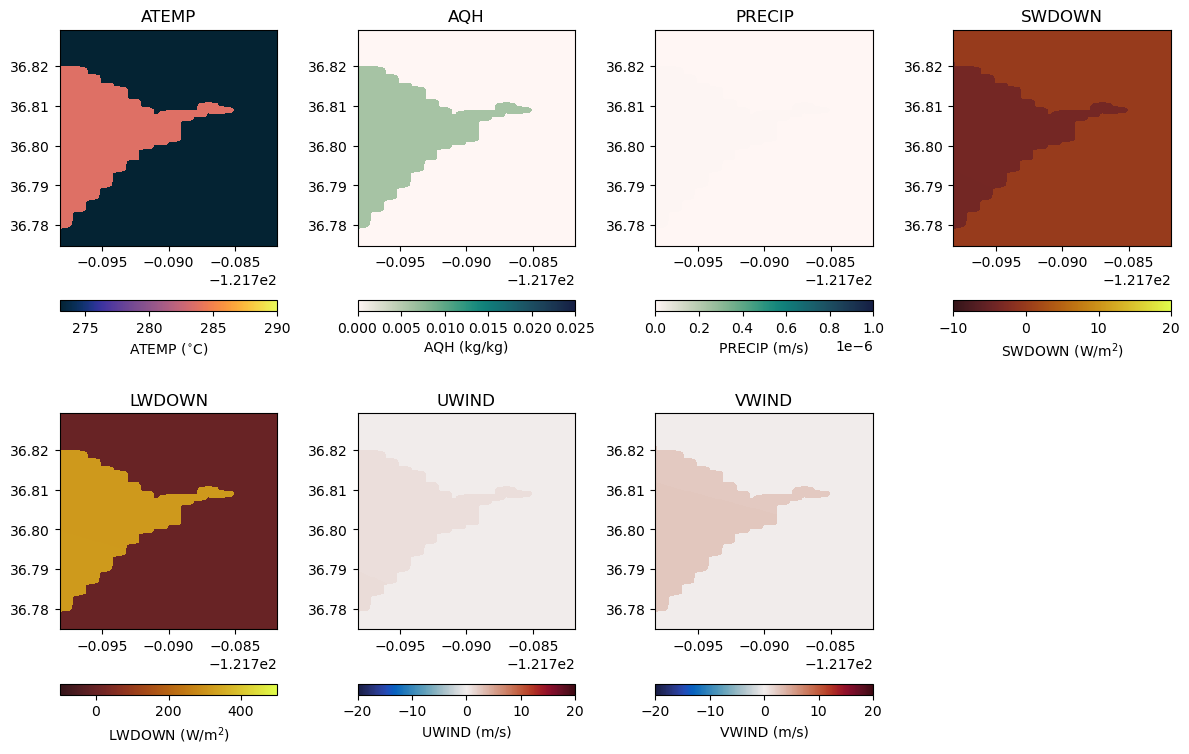

In [51]:
fig = plt.figure(figsize=(12,8))

timestep = 0

for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    CA_exf_grid = np.fromfile(os.path.join(input_dir,'exf',variable_name+'_'+str(year)),'>f4')
    CA_exf_grid = CA_exf_grid.reshape((n_timesteps, np.shape(XC)[0], np.shape(YC)[1]))
    CA_exf_grid = CA_exf_grid[timestep, :, :] # choose th
    
    plt.subplot(2,4,i+1)
    C = plt.pcolormesh(XC, YC, CA_exf_grid,
                       vmin=meta_dict[variable_names[i]][0],
                       vmax=meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2])
    plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',
                 fraction=0.26, orientation='horizontal')

    plt.title(variable_name)

plt.tight_layout()

plt.show()

Looks good! Now we need to make our external forcing and boundary conditions before we're ready to run the model.